In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm 
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DownloadProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

""" 
    check if the data (zip) file is already downloaded
    if not, download it from "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz" and save as cifar-10-python.tar.gz
"""
if not isfile('cifar-10-python.tar.gz'):
    with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels


In [3]:
def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
    
    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))
    
    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))
    
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    
    plt.imshow(sample_image)


Stats of batch #3:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 994
Label Counts of [1](AUTOMOBILE) : 1042
Label Counts of [2](BIRD) : 965
Label Counts of [3](CAT) : 997
Label Counts of [4](DEER) : 990
Label Counts of [5](DOG) : 1029
Label Counts of [6](FROG) : 978
Label Counts of [7](HORSE) : 1015
Label Counts of [8](SHIP) : 961
Label Counts of [9](TRUCK) : 1029

Example of Image 9999:
Image - Min Value: 3 Max Value: 242
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


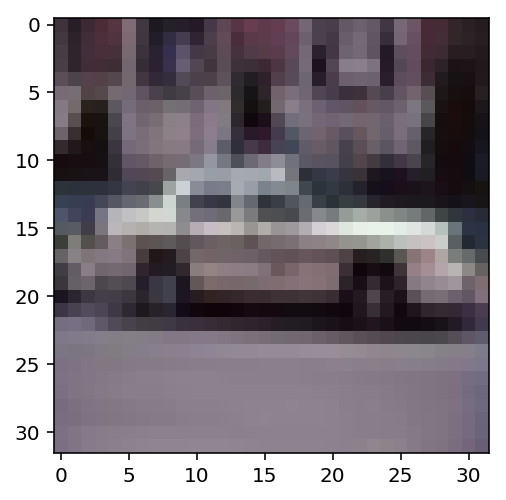

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore the dataset
batch_id = 3
sample_id = 9999
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [8]:
features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
sample_image = features[0]
#plt.imshow(sample_image)
X_test = features[0:200]
y_test = labels[0:200]
X_test.shape

(200, 32, 32, 3)

In [9]:
from sklearn.utils import shuffle

X_test, y_test = shuffle(X_test, y_test)

In [10]:
import tensorflow as tf

EPOCHS = 10
BATCH_SIZE = 128

In [63]:
import os
session = tf.Session()
saver = tf.train.Saver()
save_dir = 'checkpoints_lenetMinst/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_path = os.path.join(save_dir, 'best_validation')
#session.run(tf.global_variables_initializer())
init = tf.global_variables_initializer()
session.run(init)
try:
    print("Trying to restore last checkpoint ...")

    # Use TensorFlow to find the latest checkpoint - if any.
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

    # Try and load the data in the checkpoint.
    saver.restore(session, save_path=last_chk_path)

    # If we get to this point, the checkpoint was successfully loaded.
    print("Restored checkpoint from:", last_chk_path)
except:
    # If the above failed for some reason, simply
    # initialize all the variables for the TensorFlow graph.
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.global_variables_initializer())


Trying to restore last checkpoint ...
Failed to restore checkpoint. Initializing variables instead.


In [64]:
sigma = 0.1
conv1_w = tf.Variable(tf.truncated_normal(shape = [5,5,1,6],mean = 0, stddev = 0.1))
conv2_w = tf.Variable(tf.truncated_normal(shape = [5,5,6,16], mean = 0, stddev = 0.1))
fc1_w = tf.Variable(tf.truncated_normal(shape = (400,120), mean = 0, stddev = sigma))
fc2_w = tf.Variable(tf.truncated_normal(shape = (120,84), mean = 0, stddev = sigma))
fc3_w = tf.Variable(tf.truncated_normal(shape = (84,10), mean = 0 , stddev = sigma))

session.run(tf.global_variables_initializer())


In [65]:
def restoreWeights():
    for wIdx in range(0, len(weightsConvMat)):
        assign_op = weightsConvMat[wIdx].assign(wOrigConv[wIdx])
        session.run(assign_op)
    
    for wIdx in range(0, len(weightsFcMat)):
        assign_op = weightsFcMat[wIdx].assign(wOrigFc[wIdx])
        session.run(assign_op)

## store the original weights

In [67]:
wConvOrig1 = session.run(conv1_w)
wConvOrig2 = session.run(conv2_w)
wFcOrig1 = session.run(fc1_w)
wFcOrig2 = session.run(fc2_w)
wFcOrig3 = session.run(fc3_w)

In [68]:
wOrigConv = [wConvOrig1, wConvOrig2 ]
wOrigFc = [wFcOrig1, wFcOrig2, wFcOrig3]

In [69]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    layer_depth = {
        'layer_1' : 6,
        'layer_2' : 16,
        'layer_3' : 120,
        'layer_f1' : 84
    }

    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x,conv1_w, strides = [1,1,1,1], padding = 'VALID') + conv1_b 
    # TODO: Activation.
    conv1 = tf.nn.relu(conv1)

    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    pool_1 = tf.nn.max_pool(conv1,ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    #conv2_w = tf.Variable(tf.truncated_normal(shape = [5,5,6,16], mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(pool_1, conv2_w, strides = [1,1,1,1], padding = 'VALID') + conv2_b
    # TODO: Activation.
    conv2 = tf.nn.relu(conv2)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    pool_2 = tf.nn.max_pool(conv2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID') 
    
    # TODO: Flatten. Input = 5x5x16. Output = 400.
    fc1 = flatten(pool_2)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    #fc1_w = tf.Variable(tf.truncated_normal(shape = (400,120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc1,fc1_w) + fc1_b
    
    # TODO: Activation.
    fc1 = tf.nn.relu(fc1)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    #fc2_w = tf.Variable(tf.truncated_normal(shape = (120,84), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1,fc2_w) + fc2_b
    # TODO: Activation.
    fc2 = tf.nn.relu(fc2)
    
    # TODO: Layer 5: Fully Connected. Input = 84. Output = 10.
    #fc3_w = tf.Variable(tf.truncated_normal(shape = (84,10), mean = mu , stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(10))
    logits = tf.matmul(fc2, fc3_w) + fc3_b
    return logits, conv1, conv2, fc1, fc2

In [70]:
a = tf.placeholder(tf.float32, (200,32,32,3))
x_image = tf.reshape(a, [-1, 32, 32, 1])

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 10)
init = tf.global_variables_initializer()
session.run(init)

In [71]:
rate = 0.001

logits, conv1, conv2, fc1, fc2= LeNet(x_image)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)


print(conv2_w)

Tensor("Variable_16/read:0", shape=(5, 5, 6, 16), dtype=float32)


In [199]:
MEFullyConnected1Graphs = []
MEFullyConnected2Graphs = []
MEFullyConnected3Graphs = []

## weightsConvMat and weightsFcMat
# RUN FROM HERE ON OUT

In [200]:
restoreWeights()

In [201]:
weightsConvMat = [conv1_w, conv2_w]
weightsFcMat = [fc1_w, fc2_w, fc3_w]


wConv1 = session.run(conv1_w)
wConv2 = session.run(conv2_w)
wFc1 = session.run(fc1_w)
wFc2 = session.run(fc2_w)
wFc3 = session.run(fc3_w)

wConv = [wConv1, wConv2]
wFc = [wFc1, wFc2, wFc3]
session.run(tf.global_variables_initializer())

In [140]:
wConv

[array([[[[-0.02037592,  0.02038343, -0.02363743,  0.11253529,
           -0.03006167,  0.06694656]],
 
         [[-0.01438504, -0.14687237, -0.03535876, -0.00560432,
            0.02212945,  0.02930719]],
 
         [[ 0.01870734,  0.08101544,  0.07427964,  0.05395595,
            0.1484406 ,  0.11660083]],
 
         [[ 0.01869655,  0.05073424,  0.13814668, -0.00261085,
           -0.02639354, -0.05035699]],
 
         [[ 0.07704043,  0.0380272 ,  0.01788316, -0.06083136,
            0.07324027, -0.08505962]]],
 
 
        [[[ 0.00477531,  0.17110887, -0.08253193, -0.03668387,
            0.09496412,  0.06654304]],
 
         [[-0.08464339, -0.07703318, -0.04261924, -0.119551  ,
            0.12254816, -0.07800577]],
 
         [[ 0.16288988, -0.10166045,  0.06756315,  0.0358531 ,
            0.12279927, -0.00029856]],
 
         [[ 0.03595615,  0.08504862, -0.09756952, -0.17767039,
            0.09335599,  0.01125882]],
 
         [[-0.1966416 , -0.09607543, -0.10868313, -0.04593578

## create a list to hold the differences

In [202]:
wDiffConv = []+ wOrigConv
wDiffFc = []+ wOrigFc


## alternative filters

In [74]:
def centroidFilter(wtListConv,wtListFc):
    num = len(wtListConv)
    
    for wtMat in wtListConv:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        numChnls = shape[2]
        numFilters = shape[3]

        for c in range(0,numChnls):
            for i in range(0,numFilters):
                for j in range(0,xlen,2):
                    for k in range(0,ylen,2):
                        first = wtMat[j,k,c,i]
                        if j+1 < xlen:
                            second = wtMat[j+1,k,c,i]
                        else:
                            second = 0
                        if k+1 < xlen:
                            third = wtMat[j,k+1,c,i]
                        else:
                            third = 0
                        if j+1 < xlen and k+1 < ylen:
                            forth = wtMat[j+1,k+1,c,i]
                        else:
                            forth = 0
                        total = 0.0
                        total = float(first + second + third + forth)
                        total /= 4
                        wtMat[j,k,c,i] = total
                        if j+1 < xlen:
                            wtMat[j+1,k,c,i] = total
                        if k+1 < xlen:
                            wtMat[j,k+1,c,i] = total
                        if j+1 < xlen and k+1 < ylen:
                            wtMat[j+1,k+1,c,i] = total
                        #if wtMat[j,k,0,i] < 0:
                        #    wtMat[j,k,0,i] = 0#float('%.5f'%(w[j,k,0,i]))
                        
    for wtMat in wtListFc:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        
        for i in range(0,xlen):
            j=0
            while j<ylen:
                first = wtMat[i,j] 
                second = wtMat[i,j+1]
                avg = (first+second)/2
                wtMat[i,j] = avg
                wtMat[i,j+1] = avg
                j = j+2

In [75]:
def truncateGeneral(wtListConv,wtListFc, digits):
    import math
    num = len(wtListConv)
    
    
    for wtMat in wtListConv:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        numChnls = shape[2]
        numFilters = shape[3]

        for c in range(0,numChnls):
            for i in range(0,numFilters):
                for j in range(0,xlen):
                    for k in range(0,ylen):
                        stepper = pow(10.0, digits)
                        #wtMat[j,k,c,i] = float('%.5f'%(wtMat[j,k,c,i]))
                        wtMat[j,k,c,i] = math.trunc(stepper*wtMat[j,k,c,i]) / stepper
                        
                        
    for wtMat in wtListFc:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        
        for i in range(0,xlen):
            j=0
            while j<ylen:
                stepper = pow(10.0, digits)
                wtMat[i,j]=math.trunc(stepper*wtMat[i,j]) / stepper
                j=j+1;

In [76]:
def roundSignificant(wtListConv, wtListFc):
    import math
    from math import log10, floor
    num = len(wtListConv)
    
    
    for wtMat in wtListConv:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        numChnls = shape[2]
        numFilters = shape[3]

        for c in range(0,numChnls):
            for i in range(0,numFilters):
                for j in range(0,xlen):
                    for k in range(0,ylen):
                        #stepper = pow(10.0, digits)
                        #wtMat[j,k,c,i] = float('%.5f'%(wtMat[j,k,c,i]))
                        #num = wtMat[j,k,c,i]
                        wtMat[j,k,c,i] = round(wtMat[j,k,c,i], -int(floor(log10(abs(wtMat[j,k,c,i])))))
                        #wtMat[j,k,c,i] = math.trunc(stepper*wtMat[j,k,c,i]) / stepper
                        
                        
    for wtMat in wtListFc:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        
        for i in range(0,xlen):
            j=0
            while j<ylen:
                #stepper = pow(10.0, digits)
                wtMat[i,j]=round(wtMat[i,j], -int(floor(log10(abs(wtMat[i,j])))))
                j=j+1;

In [205]:
truncateGeneral(wConv, wFc, 5)

## assign filters

In [143]:
def assignFilters(wConv,wFc):
    for wIdx in range(0,len(weightsConvMat)):
        assign_op = weightsConvMat[wIdx].assign(wConv[wIdx])
        session.run(assign_op)
        
    for wIdx in range(0,len(weightsFcMat)):
        assign_op = weightsFcMat[wIdx].assign(wFc[wIdx])
        session.run(assign_op)

In [206]:
assignFilters(wConv,wFc)

In [80]:
def loadValues(numImg):
    
    
    feed_dict = {a: imageTest}
    values_conv1 = session.run(conv1, feed_dict=feed_dict)
    values_conv2 = session.run(conv2, feed_dict=feed_dict)
    #values_conv4 = session.run(conv4, feed_dict = feed_dict)
    values_fc1 = session.run(fc1, feed_dict = feed_dict)
    values_fc2 = session.run(fc2, feed_dict = feed_dict)
    values_fc3 = session.run(logits, feed_dict = feed_dict)
    #values_fc4 = session.run(fc4, feed_dict = feed_dict)
    #values_out = session.run(out, feed_dict = feed_dict)

    valuesConvMat = [values_conv1, values_conv2]
    valuesFcMat = [values_fc1, values_fc2, values_fc3]
    
    return valuesConvMat, valuesFcMat, numImg

## static approx

In [81]:
def calculateStaticDiff(wConv, wFc, wOrigConv, wOrigFc):
    for i in range(len(wConv)):
        wDiffConv[i] = abs(wOrigConv[i]-wConv[i])
    for i in range(len(wFc)):
        wDiffFc[i] = abs(wOrigFc[i] - wFc[i])

## dynamic approx

In [82]:
def calculateDynamicDiff(wConv, wFc, wOrigConv, wOrigFc):
    wConvSorted = [] + wConv
    wConvOrigSorted = [] + wOrigConv
    wFcSorted = [] + wFc
    wFcOrigSorted = [] + wOrigFc
    for i in range(len(wConv)):
        wConvSorted[i] = np.sort(wConv[i])
        wConvOrigSorted[i] = np.sort(wOrigConv[i])
    for i in range(len(wFc)):
        wFcSorted[i] = np.sort(wFc[i])
        wFcOrigSorted[i] = np.sort(wOrigFc[i])
    for i in range(len(wConv)):
        wDiffConv[i] = np.absolute( wConvOrigSorted[i] - wConvSorted[i])
    for i in range(len(wFc)):
        wDiffFc[i] = np.absolute( wFcOrigSorted[i] - wFcSorted[i])

In [214]:
 calculateDynamicDiff(wConv, wFc, wOrigConv, wOrigFc)

In [215]:
wDiffConv

[array([[[[1.66520476e-06, 7.42636621e-06, 1.59181654e-05,
           1.34315342e-05, 6.55651093e-06, 5.28991222e-06]],
 
         [[2.36928463e-06, 1.87605619e-05, 1.50399283e-05,
           1.43232755e-05, 9.44733620e-06, 7.18981028e-06]],
 
         [[1.73449516e-05, 5.94928861e-06, 9.64105129e-06,
           1.54376030e-05, 1.08331442e-05, 5.96046448e-07]],
 
         [[1.69910491e-05, 1.35377049e-05, 8.49599019e-07,
           1.65514648e-05, 4.23938036e-06, 1.66893005e-05]],
 
         [[9.61869955e-06, 1.35600567e-06, 3.16090882e-06,
           1.72033906e-05, 1.02669001e-05, 4.24683094e-07]]],
 
 
        [[[1.19283795e-05, 3.87057662e-06, 1.53095461e-05,
           3.03238630e-06, 1.41263008e-05, 8.86619091e-06]],
 
         [[1.10045075e-05, 1.33886933e-05, 5.76674938e-06,
           3.17394733e-06, 9.23871994e-06, 1.81645155e-05]],
 
         [[1.04457140e-05, 1.85645476e-05, 1.30981207e-05,
           3.14414501e-06, 9.26852226e-06, 9.87946987e-06]],
 
         [[3.87430191

In [85]:
def calculateConvME(valuesMat):
    shape = valuesMat.shape
    valMat = valuesMat
    numFilters = shape[3]
    means = np.zeros(numFilters)
    meanSum = np.zeros(numFilters)
    
    for nImg in range(0,numImg):
        meanSum = meanSum + means/numFilters
        for i in range(0,numFilters):
            result = valMat[nImg,:,:,i]
            result_sum = np.sum(result)
            means[i] = result_sum

            
    posME = []
    for sort in meanSum:
        if sort<0:
            sort = sort * -1
            posME.append(sort)
        else :
            posME.append(sort)
            
            

    #print(result.shape)       
    average = [x / numImg for x in posME]
    averageSorted = np.sort(average)
    return average, averageSorted

In [86]:
def calculateFCME(valuesMat):
    shape = valuesMat.shape
    valMat = valuesMat
    numFilters = shape[1]
    ##print("we are in the fully connected layer function")
    ##print(valMat)
    means = np.zeros(numFilters)
    meanSum = np.zeros(numFilters)

    for nImg in range(0,numImg):
        meanSum = meanSum + means/numFilters
        for i in range(0,numFilters):
            result = valMat[nImg,i]
            result_sum = np.sum(result)
            means[i] = result_sum
    
    posList = []
    for i in meanSum:
        if i<0:
            i = i*-1
        posList.append(i)
    average = [x / numImg for x in posList]
    averageSorted = np.sort(average)
    return average, averageSorted

In [60]:
def plotMEConvolution(ME1, ME2):
    x1 = np.arange(len(ME1))
    x2 = np.arange(len(ME2))
    plt.bar(x1, ME1, color = 'b', align = 'center')
    d1=  len(ME1) + 1
    plt.bar(x2+d1, ME2, color = 'g', align = 'center')

In [131]:
def plotMEFullyConnected(ME1, ME2, ME3):
    x1 = np.arange(len(ME1))
    x2 = np.arange(len(ME2))  
    x3 = np.arange(len(ME3))
    plt.bar(x1, ME1, color = 'b', align = 'center')
    d1=  len(ME1) + 1
    plt.bar(x2+d1, ME2, color = 'g', align = 'center')
    d2 = d1 + len(ME2) + 1
    plt.bar(x3 + d2, ME3, color='r', align = 'center')

In [216]:
session.run(tf.global_variables_initializer())
assignFilters(wConv,wFc)
assign_op = weightsFcMat[0].assign(wDiffFc[0])
session.run(assign_op)
assign_op = weightsConvMat[0].assign(wDiffConv[0])
session.run(assign_op)

###### LAYER 1 ######
valuesConvMat, valuesFcMat, numImg = loadValues(100)
MEConv1,MEConv1Sorted = calculateConvME(valuesConvMat[0])
MEFullyConnected1, MEFullyConnected1Sorted = calculateFCME(valuesFcMat[0])
#MEConv1 = calculateConvMEDynamic(valuesConvMat[0])
#MEFullyConnected1 = calculateFCMEDynamic(valuesFcMat[0])

assignFilters(wConv,wFc)
assign_op = weightsFcMat[1].assign(wDiffFc[1])
session.run(assign_op)
assign_op = weightsConvMat[1].assign(wDiffConv[1])
session.run(assign_op)

###### LAYER 2 ######
valuesConvMat,valuesFcMat,numImg = loadValues(100)
MEConv2,MEConv2Sorted = calculateConvME(valuesConvMat[1])
MEFullyConnected2, MEFullyConnected2Sorted = calculateFCME(valuesFcMat[1])
#MEConv2 = calculateConvMEDynamic(valuesConvMat[1])
#MEFullyConnected2 = calculateFCMEDynamic(valuesFcMat[1])


assign_op = weightsFcMat[2].assign(wDiffFc[2])
session.run(assign_op)
valuesConvMat,valuesFcMat,numImg = loadValues(100)
#MEConv1 = calculateConvMEDynamic(valuesConvMat[0])
#MEFullyConnected3 = calculateFCMEDynamic(valuesFcMat[2])
MEFullyConnected3, MEFullyConnected3Sorted = calculateFCME(valuesFcMat[2])

#MEConvMat = [MEConv1Sorted, MEConv2Sorted]
#print(MEConv1Sorted)
#MEFullyConnectedMat = [MEFullyConnected1Sorted, MEFullyConnected2Sorted, ]
print("end of function")

end of function


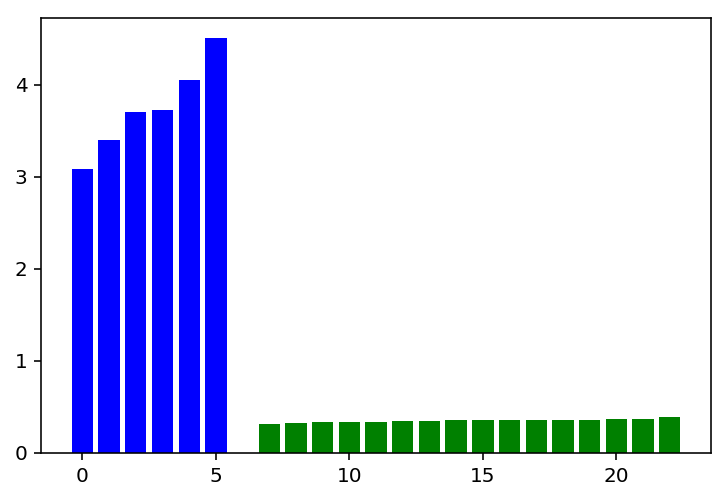

In [210]:
plotMEConvolution(MEConv1Sorted, MEConv2Sorted)

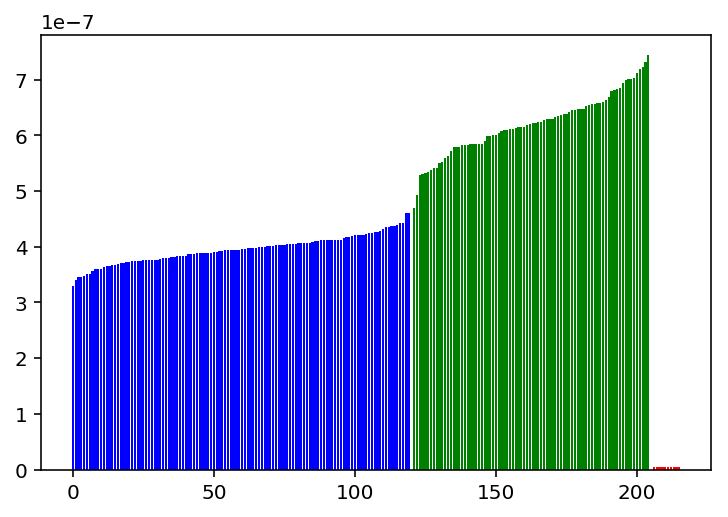

In [211]:
plotMEFullyConnected(MEFullyConnected1Sorted, MEFullyConnected2Sorted, MEFullyConnected3Sorted)

In [217]:
MEFullyConnected1Graphs.append(MEFullyConnected1Sorted)
MEFullyConnected2Graphs.append(MEFullyConnected2Sorted)
MEFullyConnected3Graphs.append(MEFullyConnected3Sorted)

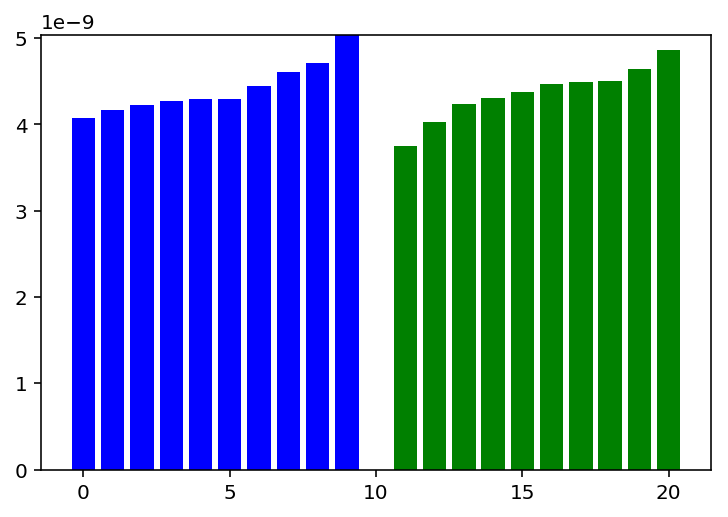

In [218]:
plotMEConvolution(MEFullyConnected3Graphs[0], MEFullyConnected3Graphs[1])

In [249]:
def plotDiff(ME1, ME2):
    x1 = np.arange(len(ME1))
    x2 = np.arange(len(ME2))
   # x3 = np.arange(len(ME3))
    plt.bar(x1, ME1, color = 'blue', align = 'center', alpha = 1)
    plt.bar(x2, ME2, color = 'red', align = 'center', alpha = 0.7)
    #plt.bar(x3, ME3, color = 'green', align = 'center', alpha = 0.6)

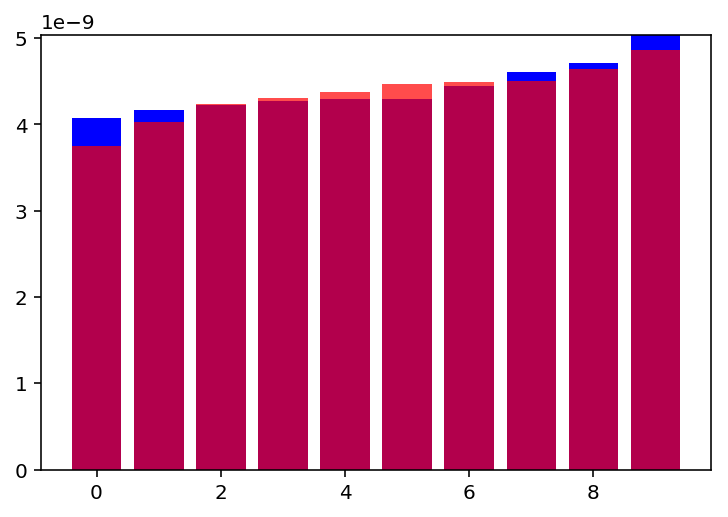

In [250]:

plotDiff(MEFullyConnected3Graphs[0], MEFullyConnected3Graphs[1])

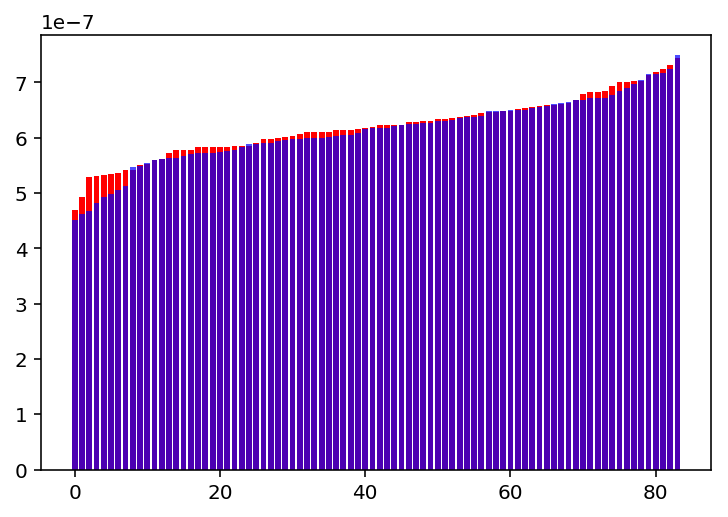

In [237]:
plotDiff(MEFullyConnected2Graphs[0], MEFullyConnected2Graphs[1])

In [238]:
sum1 = 0
sum2 = 0
for i in MEFullyConnected2Graphs[0]:
    sum1 = sum1 + i
  
for i in MEFullyConnected2Graphs[1]:
    sum2 = sum2 + i

In [251]:
print(sum2 - sum1)

-6.662131534626979e-07


In [240]:
print(sum1)
print(sum2)

5.209885169279009e-05
5.143263853932739e-05
